In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Adversarial regularization for image classification

## Overview

In this tutorial, we will explore the use of adversarial learning
([Goodfellow et al., 2014](https://arxiv.org/abs/1412.6572)) for image
classification using the Neural Structured Learning (NSL) framework.

The core idea of adversarial learning is to train a model with adversarially-perturbed data (called adversarial examples) in addition to the organic training data. To the human eye, these adversarial examples look the same as the original but the perturbation will cause the model to be confused and make incorrect predictions or classifications. The adversarial examples are constructed to intentionally mislead the model into making wrong predictions or classifications. By training with such examples, the model learns to be robust against adversarial perturbation when making predictions.

In this tutorial, we illustrate the following procedure of applying adversarial
learning to obtain robust models using the Neural Structured Learning framework:

1.  Create a neural network as a base model. In this tutorial, the base model is
    created with the `tf.keras` functional API; this procedure is compatible
    with models created by `tf.keras` sequential and subclassing APIs as well.
    For more information on Keras models in TensorFlow, see this [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
2.  Wrap the base model with the **`AdversarialRegularization`** wrapper class,
    which is provided by the NSL framework, to create a new `tf.keras.Model`
    instance. This new model will include the adversarial loss as a
    regularization term in its training objective.
3.  Convert examples in the training data to feature dictionaries.
4.  Train and evaluate the new model.

## Recap for Beginners



There is a corresponding [video explanation](https://youtu.be/Js2WJkhdU7k) on adversarial learning for image classification part of the TensorFlow Neural Structured Learning Youtube series. Below, we have summarized the key concepts explained in this video, expanding on the explanation provided in the Overview section above.

The NSL framework jointly optimizes both image features and structured signals to help neural networks better learn. However, what if there is no explicit structure available to train the neural network? This tutorial explains one approach involving the creation of adversarial neighbors (modified from the original sample) to dynamically construct a structure.

Firstly, adversarial neighbors are defined as modified versions of the sample image applied with small perturbations that mislead a neural net into outputting inaccurate classifications. These carefully designed perturbations are typically based on the reverse gradient direction and are meant to confuse the neural net during training. Humans may not be able to tell the difference between a sample image and it's generated adversarial neighbor. However, to the neural net, the applied perturbations are effective at leading to an inaccurate conclusion. 

Generated adversarial neighbors are then connected to the sample, therefore dynamically constructing a structure edge by edge. Using this connection, neural nets learn to maintain the similarities between the sample and the adversarial neighbors while avoiding confusion resulting from misclassifications, thus improving the overall neural network's quality and accuracy. 

The code segment below is a high-level explanation of the steps involved while the rest of this tutorial goes into further depth and technicality.

1. Read and prepare the data. Load the MNIST dataset and normalize the feature values to stay in the range [0,1]
```
import neural_structured_learning as nsl

(x_train, y_train), (x_train, y_train) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
```

2. Build the neural network. A Sequential Keras base model is used for this example.
```
model = tf.keras.Sequential(...)
```


3. Configure the adversarial model. Including the hyperparameters: multiplier applied on the adversarial regularization, empirically chosen differ values for step size/learning rate. Invoke adversarial regularization with a wrapper class around the constructed neural network.
```
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config)
```

4. Conclude with the standard Keras workflow: compile, fit, evaluate.
```
adv_model.compile(optimizer='adam', loss='sparse_categorizal_crossentropy', metrics=['accuracy'])
adv_model.fit({'feature': x_train, 'label': y_train}, epochs=5)
adv_model.evaluate({'feature': x_test, 'label': y_test})
```

What you see here is adversarial learning enabled in 2 steps and 3 simple lines of code. This is the simplicity of the neural structured learning framework. In the following sections, we expand upon this procedure.

## Setup

Install the Neural Structured Learning package.

In [2]:
!pip install --quiet neural-structured-learning

Import libraries. We abbreviate `neural_structured_learning` to `nsl`.

In [3]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

2022-12-14 12:13:55.384148: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:13:55.384262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:13:55.384274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Hyperparameters

We collect and explain the hyperparameters (in an `HParams` object) for model
training and evaluation.

Input/Output:

*   **`input_shape`**: The shape of the input tensor. Each image is 28-by-28
pixels with 1 channel.
*   **`num_classes`**: There are a total of 10 classes, corresponding to 10
digits [0-9].

Model architecture:

*   **`conv_filters`**: A list of numbers, each specifying the number of
filters in a convolutional layer.
*   **`kernel_size`**: The size of 2D convolution window, shared by all
convolutional layers.
*   **`pool_size`**: Factors to downscale the image in each max-pooling layer.
*   **`num_fc_units`**: The number of units (i.e., width) of each
fully-connected layer.

Training and evaluation:

*  **`batch_size`**: Batch size used for training and evaluation.
*  **`epochs`**: The number of training epochs.

Adversarial learning:

*   **`adv_multiplier`**: The weight of adversarial loss in the training
objective, relative to the labeled loss.
*   **`adv_step_size`**: The magnitude of adversarial perturbation.
*  **`adv_grad_norm`**: The norm to measure the magnitude of adversarial
perturbation.


In [4]:
class HParams(object):
  def __init__(self):
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

## MNIST dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains grayscale
images of handwritten digits (from '0' to '9'). Each image shows one digit at
low resolution (28-by-28 pixels). The task involved is to classify images into
10 categories, one per digit.

Here we load the MNIST dataset from
[TensorFlow Datasets](https://www.tensorflow.org/datasets). It handles
downloading the data and constructing a `tf.data.Dataset`. The loaded dataset
has two subsets:

*   `train` with 60,000 examples, and
*   `test` with 10,000 examples.

Examples in both subsets are stored in feature dictionaries with the following
two keys:

*   `image`: Array of pixel values, ranging from 0 to 255.
*   `label`: Groundtruth label, ranging from 0 to 9.

In [5]:
datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

2022-12-14 12:13:57.703319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


To make the model numerically stable, we normalize the pixel values to [0, 1]
by mapping the dataset over the `normalize` function. After shuffling training
set and batching, we convert the examples to feature tuples `(image, label)`
for training the base model. We also provide a function to convert from tuples
to dictionaries for later use.

In [6]:
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

## Base model

Our base model will be a neural network consisting of 3 convolutional layers
follwed by 2 fully-connected layers (as defined in `HPARAMS`). Here we define
it using the Keras functional API. Feel free to try other APIs or model
architectures (e.g. subclassing). Note that the NSL framework does support all three types of Keras APIs.

In [7]:
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes)(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [8]:
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928 

Next we train and evaluate the base model.

In [9]:
base_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.1454 - acc: 0.9549
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0495 - acc: 0.9851
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0333 - acc: 0.9898
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0277 - acc: 0.9911
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0209 - acc: 0.9935


In [10]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

313/313 [==============================] - 1s 3ms/step - loss: 0.0307 - acc: 0.9909

accuracy: 0.9908999800682068


We can see that the base model achieves 99% accuracy on the test set. We will
see how robust it is in
[Robustness Under Adversarial Perturbations](#scrollTo=HXK9MGG8lBX3) below.

## Adversarial-regularized model

Here we show how to incorporate adversarial training into a Keras model with a
few lines of code, using the NSL framework. The base model is wrapped to create
a new `tf.Keras.Model`, whose training objective includes adversarial
regularization.

First, we create a config object with all relevant hyperparameters using the
helper function `nsl.configs.make_adv_reg_config`.

In [11]:
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

Now we can wrap a base model with `AdversarialRegularization`. Here we create a
new base model (`base_adv_model`), so that the existing one (`base_model`) can
be used in later comparison.

The returned `adv_model` is a `tf.keras.Model` object, whose training objective
includes a regularization term for the adversarial loss. To compute that loss,
the model has to have access to the label information (feature `label`), in
addition to regular input (feature `image`). For this reason, we convert the
examples in the datasets from tuples back to dictionaries. And we tell the
model which feature contains the label information via the `label_keys`
parameter.

In [12]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

Next we compile, train, and evaluate the
adversarial-regularized model. There might be warnings like
"Output missing from loss dictionary," which is fine because
the `adv_model` doesn't rely on the base implementation to
calculate the total loss.

In [13]:
adv_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1875/1875 [==============================] - 25s 11ms/step - loss: 0.3034 - sparse_categorical_crossentropy: 0.1414 - sparse_categorical_accuracy: 0.9582 - scaled_adversarial_loss: 0.1619
Epoch 2/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1300 - sparse_categorical_crossentropy: 0.0439 - sparse_categorical_accuracy: 0.9862 - scaled_adversarial_loss: 0.0860
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0940 - sparse_categorical_crossentropy: 0.0317 - sparse_categorical_accuracy: 0.9903 - scaled_adversarial_loss: 0.0623
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0713 - sparse_categorical_crossentropy: 0.0254 - sparse_categorical_accuracy: 0.9923 - scaled_adversarial_loss: 0.0459
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0538 - sparse_categorical_crossentropy: 0.0185 - sparse_categorical_accuracy: 0.9938 - scaled_adversarial_loss: 0.0353


In [14]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

313/313 [==============================] - 2s 6ms/step - loss: 0.0725 - sparse_categorical_crossentropy: 0.0275 - sparse_categorical_accuracy: 0.9911 - scaled_adversarial_loss: 0.0449

accuracy: 0.991100013256073


We can see that the adversarial-regularized model also performs very well (99%
accuracy) on the test set.

## Robustness under Adversarial perturbations

Now we compare the base model and the adversarial-regularized model for
robustness under adversarial perturbation.

We will use the `AdversarialRegularization.perturb_on_batch` function for
generating adversarially perturbed examples. And we would like the generation
based on the base model. To do so, we wrap the base model with
`AdversarialRegularization`. Note that as long as we don't invoke training (`Model.fit`), the learned variables in the model won't change and the model is
still the same one as in section [Base Model](#scrollTo=JrrMpPNmpCKK).

In [15]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model, label_keys=[LABEL_INPUT_NAME], adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

We collect in a dictionary the models to be evaluted, and also create a metric
object for each of the models.

Note that we take `adv_model.base_model` in order to have the same input format
(not requiring label information) as the base model. The learned variables in
`adv_model.base_model` are the same as those in `adv_model`.

In [16]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

Here is the loop to generate perturbed examples and to evaluate models with
them. We save the perturbed images, labels, and predictions for visualization
in the next section.

In [17]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.501200
adv-regularized model accuracy: 0.948900


We can see that the accuracy of the base model drops dramatically (from 99% to
about 50%) when the input is perturbed adversarially. On the other hand, the
accuracy of the adversarial-regularized model only degrades a little (from 99%
to 95%). This demonstrates the effectiveness of adversarial learning on
improving model's robustness.

## Examples of adversarially-perturbed images

Here we take a look at the adversarially-perturbed images. We can see that the
perturbed images still show digits recognizable by human, but can successfully
fool the base model.

accuracy in batch 0:
base model: 16 / 32
adv-regularized model: 30 / 32


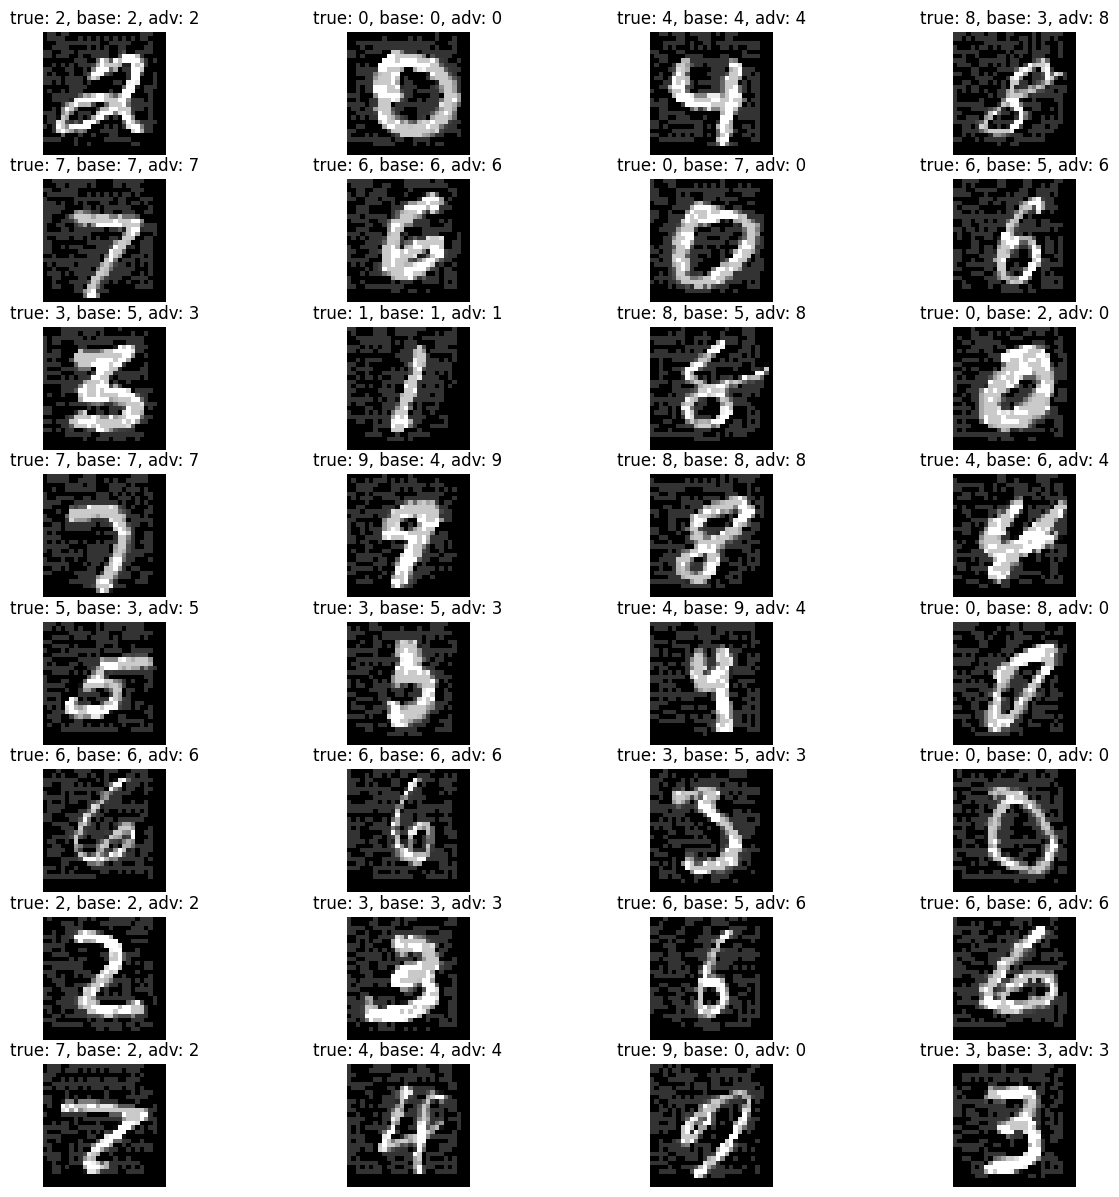

In [18]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) // n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.utils.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()

## Conclusion

We have demonstrated the use of adversarial learning for image classification
using the Neural Structured Learning (NSL) framework. We encourage users to
experiment with different adversarial settings (in hyper-parameters) and to see
how they affect model robustness.